#### Import Library

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML,display
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sklearn.metrics as metrics
plt.style.use('fivethirtyeight')
import datetime
import warnings as ws
ws.filterwarnings('ignore')
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
import string

##### Mengimport Data

In [2]:
df=pd.read_excel('Data_SST_Emisi_KonsentrasiCO2.xlsx', sheet_name='Sheet4')

In [3]:
df.head()

,Year,Month,Provinsi,CO2
0,2006,1,ACEH,406.700307
1,2006,1,BALI,384.550911
2,2006,1,BANTEN,386.357925
3,2006,1,BENGKULU,402.444452
4,2006,1,DI YOGYAKARTA,387.276678


##### Melihat jumlah data

In [4]:
df.shape

(6660, 4)

Dari output di atas, dapat dilihat bahwa data terdiri atas 6660 baris dengan 4 kolom (variabel)

##### Melihat list tahun dan provinsi pada data

In [5]:
print('Periode Tahun : ', df.Year.unique());

print("List Provinsi : ", df.Provinsi.unique());

Periode Tahun :  [2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019
 2020]
List Provinsi :  ['ACEH' 'BALI' 'BANTEN' 'BENGKULU' 'DI YOGYAKARTA' 'DKI JAKARTA'
 'GORONTALO' 'JAMBI' 'JAWA BARAT' 'JAWA TENGAH' 'JAWA TIMUR'
 'KALIMANTAN BARAT' 'KALIMANTAN SELATAN' 'KALIMANTAN TENGAH'
 'KALIMANTAN TIMUR' 'KALIMANTAN UTARA' 'KEPULAUAN BANGKA BELITUNG'
 'KEPULAUAN RIAU' 'LAMPUNG' 'MALUKU' 'MALUKU UTARA' 'NUSA TENGGARA BARAT'
 'NUSA TENGGARA TIMUR' 'PAPUA' 'PAPUA BARAT' 'PAPUA PEGUNUNGAN'
 'PAPUA SELATAN' 'PAPUA TENGAH' 'RIAU' 'SULAWESI BARAT' 'SULAWESI SELATAN'
 'SULAWESI TENGAH' 'SULAWESI TENGGARA' 'SULAWESI UTARA' 'SUMATERA BARAT'
 'SUMATERA SELATAN' 'SUMATERA UTARA']


Dari output di atas dapat dilihat bahwa data terdiri dari data tahun 2006 hingga tahun 2020 per masing-masing provinsi.

##### Membuat kolom baru quarter dari kolom month

In [6]:
def to_quarter(month):
    if month<=3:
        return 1
    elif month<=6:
        return 2
    elif month<=9:
        return 3
    else :
        return 4
    
df['quarter'] = df['Month'].apply(lambda x: to_quarter(x))

##### Melakukan sort berdasarkan kolom provinsi, year, dan month

In [7]:
df=df.sort_values(by=['Provinsi', 'Year', 'Month']).reset_index(drop=True)

In [8]:
df.dtypes

Year          int64
Month         int64
Provinsi     object
CO2         float64
quarter       int64
dtype: object

##### Mengubah tipe data Year menjadi integer

In [9]:
df['Year']=df['Year'].astype(int)

In [10]:
df

,Year,Month,Provinsi,CO2,quarter
0,2006,1,ACEH,406.700307,1
1,2006,2,ACEH,409.428947,1
2,2006,3,ACEH,408.551753,1
3,2006,4,ACEH,408.384943,2
4,2006,5,ACEH,409.190083,2
...,...,...,...,...,...
6655,2020,8,SUMATERA UTARA,438.561704,3
6656,2020,9,SUMATERA UTARA,436.415308,3
6657,2020,10,SUMATERA UTARA,438.808983,4
6658,2020,11,SUMATERA UTARA,436.731675,4


#### Train/Test Split

Selanjutnya data akan displit menjadi data train dan data test. Data dengan Year< 2018 akan menjadi data train, sedangkan sisanya menjadi data test. Artinya 3 tahun terakhir pada data yaitu tahun 2018, 2019, dan 2020 akan digunakan sebagai data test untuk mengevaluasi model prediksi CO2 per masing-masing provinsi.

In [11]:
split_year = 2018
df_train = df[df.Year < split_year].copy()
df_test = df[df.Year >= split_year].copy()

Selanjutnya dibuat function create_features untuk membuat variabel lag, rolling dengan rata-rata, standar deviasi, nilai maksimum, dan minimum dari data CO2. Hasil dari function create features ini beserta variabel year dan month akan dijadikan sebagai features, sedangkan variabel CO2 akan dijadikan sebagai label atau variabel target.

In [12]:
def create_features(data, label=None):
    
    data['CO2_3mth_lag'] = data['CO2'].shift(3)
    data['CO2_6mth_lag'] = data['CO2'].shift(6)
    data['CO2_9mth_lag'] = data['CO2'].shift(9)
    data['CO2_3mth_mean'] = data['CO2'].rolling(window = 3).mean()
    data['CO2_6mth_mean'] = data['CO2'].rolling(window = 6).mean()
    data['CO2_9mth_mean'] = data['CO2'].rolling(window = 9).mean()
    data['CO2_3mth_std'] = data['CO2'].rolling(window = 3).std()
    data['CO2_6mth_std'] = data['CO2'].rolling(window = 6).std()
    data['CO2_9mth_std'] = data['CO2'].rolling(window = 9).std()
    data['CO2_3mth_max'] = data['CO2'].rolling(window = 3).max()
    data['CO2_6mth_max'] = data['CO2'].rolling(window = 6).max()
    data['CO2_9mth_max'] = data['CO2'].rolling(window = 9).max()
    data['CO2_3mth_min'] = data['CO2'].rolling(window = 3).min()
    data['CO2_6mth_min'] = data['CO2'].rolling(window = 6).min()
    data['CO2_9mth_min'] = data['CO2'].rolling(window = 9).min()

    features=['Year', 'Month', 'CO2', 'quarter', 'CO2_3mth_lag',
       'CO2_6mth_lag', 'CO2_9mth_lag', 'CO2_3mth_mean', 'CO2_6mth_mean',
       'CO2_9mth_mean', 'CO2_3mth_std', 'CO2_6mth_std', 'CO2_9mth_std',
       'CO2_3mth_max', 'CO2_6mth_max', 'CO2_9mth_max', 'CO2_3mth_min',
       'CO2_6mth_min', 'CO2_9mth_min']
    
    X = data[features]
    if label:
        y = data[label]
        return X, y

Kemudian dibuat function regression_results untuk menghasilkan metrics seperti MAE, MSE dan Rsquare pada model masing-masing provinsi nantinya.

In [13]:
def regression_results(y_true, y_pred):
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    return ''

Selanjutnya dilakukan pemodelan per provinsi menggunakan lasso regression yang dilatih pada data train dan dievaluasi pada data test. Hasil akhir menghasilkan metrics evaluasi seperti MAE, MSE, Rsquare, dan Hasil plot antara nilai actual CO2 dengan hasil prediksi menggunakan model untuk masing-masing provinsi. 

explained_variance:  0.9993
r2:  0.9816
MAE:  0.4383
MSE:  0.2003
RMSE:  0.4475



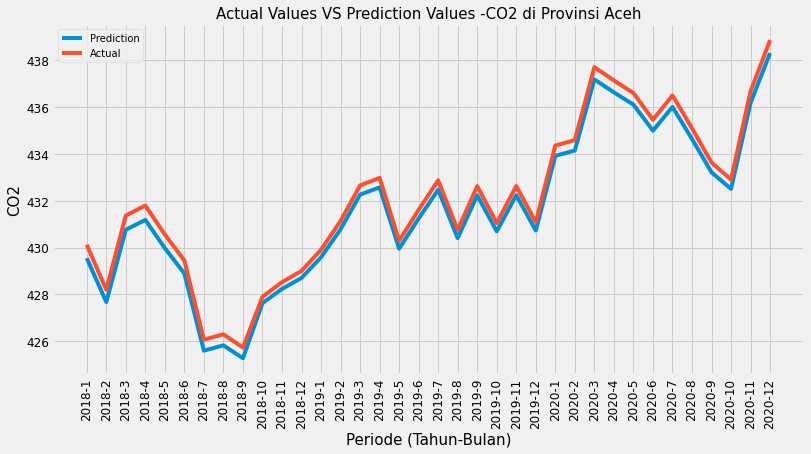

explained_variance:  0.999
r2:  0.9793
MAE:  0.4595
MSE:  0.2217
RMSE:  0.4709



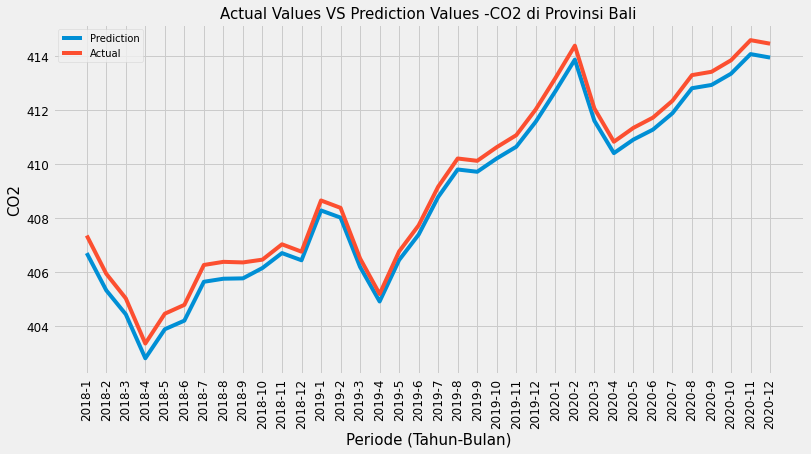

explained_variance:  0.9994
r2:  0.991
MAE:  0.3863
MSE:  0.1592
RMSE:  0.399



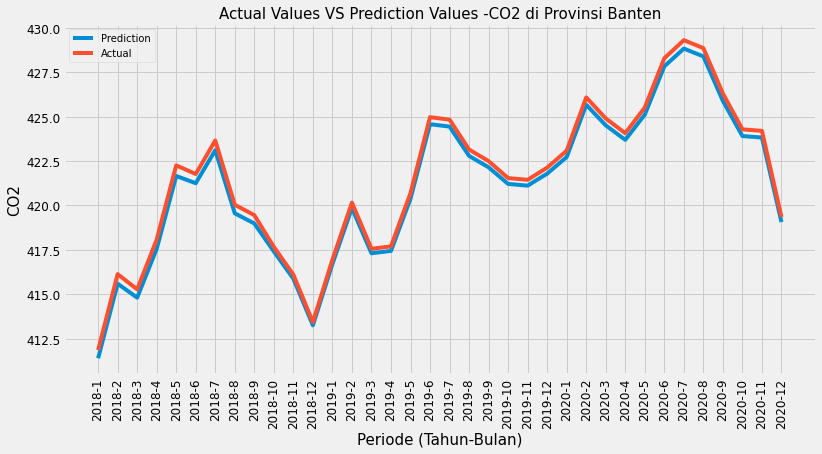

explained_variance:  0.9996
r2:  0.9939
MAE:  0.3615
MSE:  0.1398
RMSE:  0.3739



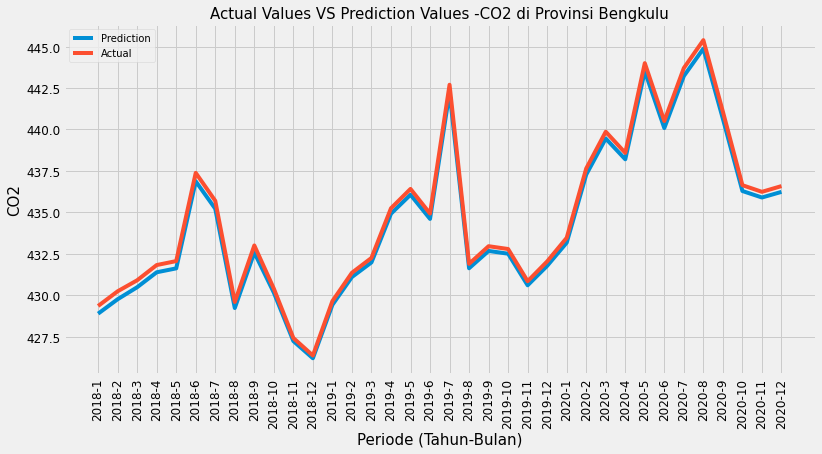

explained_variance:  0.9992
r2:  0.9871
MAE:  0.3865
MSE:  0.1596
RMSE:  0.3995



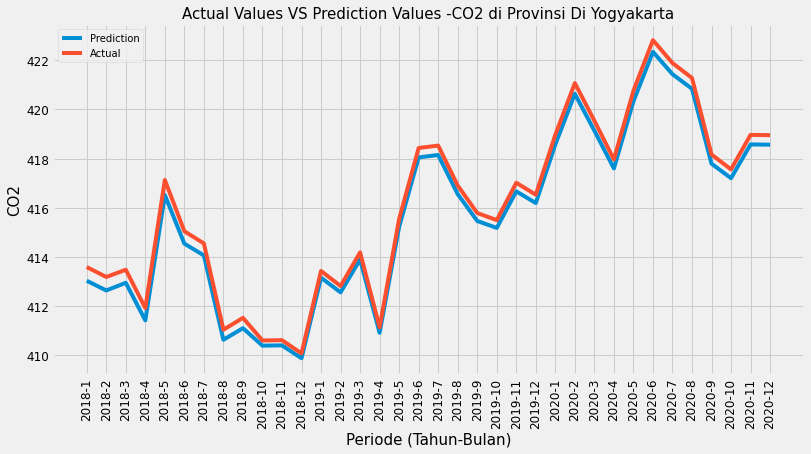

explained_variance:  0.9994
r2:  0.9949
MAE:  0.2491
MSE:  0.0699
RMSE:  0.2644



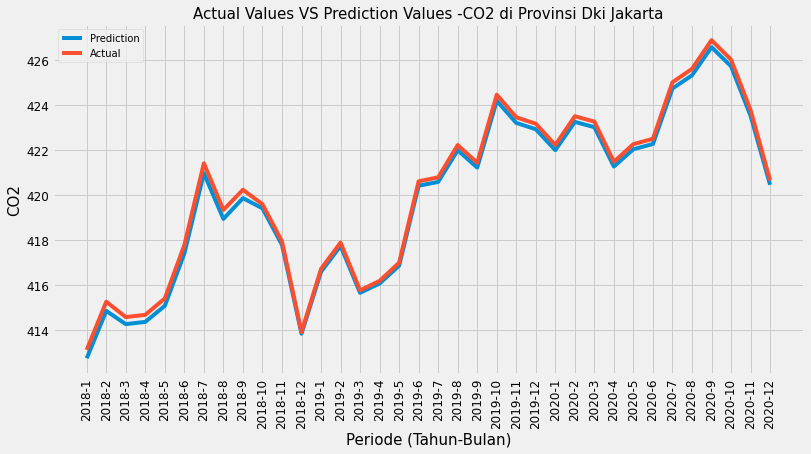

explained_variance:  0.9989
r2:  0.9727
MAE:  0.4977
MSE:  0.2581
RMSE:  0.508



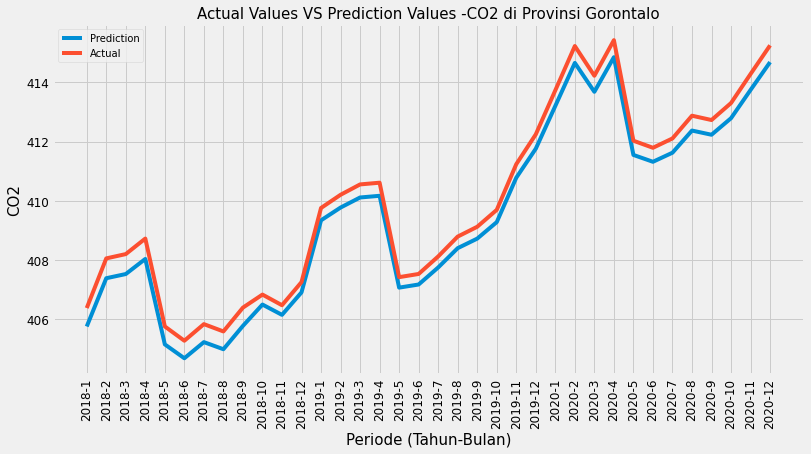

explained_variance:  0.9998
r2:  0.9979
MAE:  0.2756
MSE:  0.0849
RMSE:  0.2914



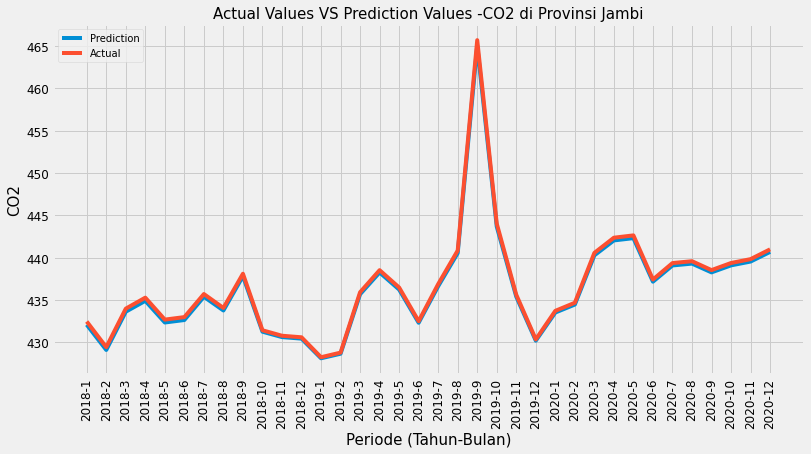

explained_variance:  0.9993
r2:  0.9899
MAE:  0.4124
MSE:  0.1824
RMSE:  0.4271



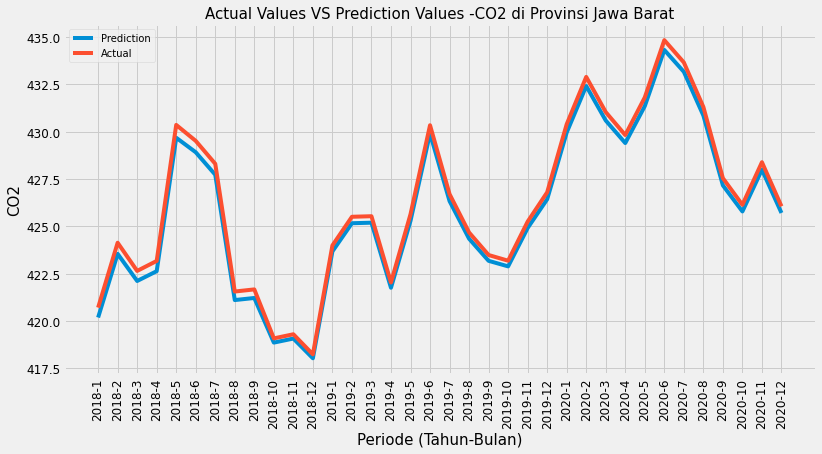

explained_variance:  0.9994
r2:  0.9919
MAE:  0.3505
MSE:  0.1334
RMSE:  0.3652



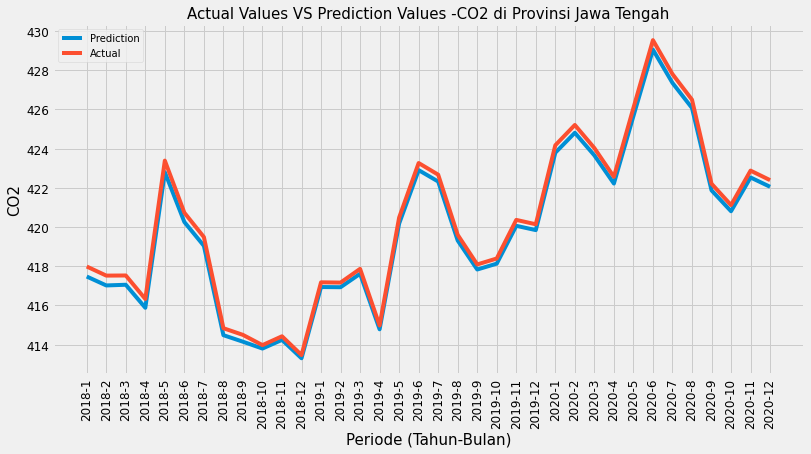

explained_variance:  0.9995
r2:  0.9924
MAE:  0.3816
MSE:  0.1555
RMSE:  0.3943



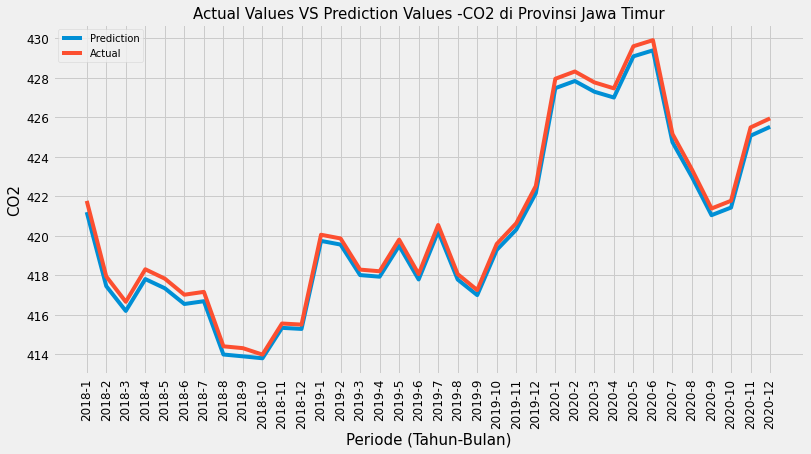

explained_variance:  0.9998
r2:  0.9974
MAE:  0.2767
MSE:  0.0845
RMSE:  0.2906



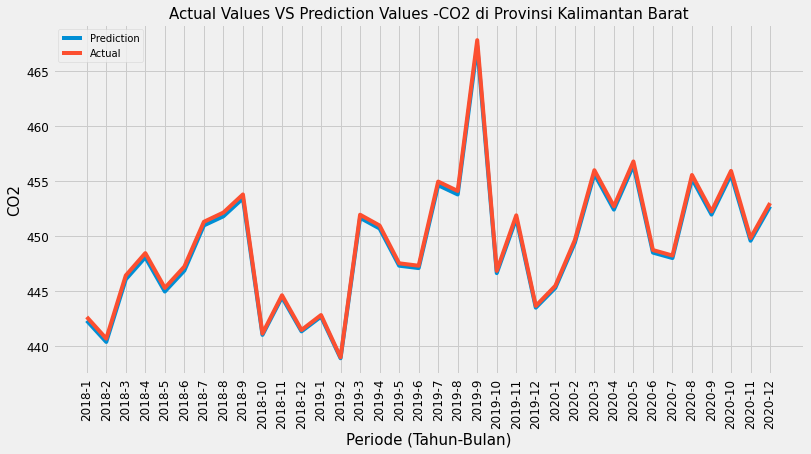

explained_variance:  0.9994
r2:  0.9928
MAE:  0.3944
MSE:  0.1697
RMSE:  0.412



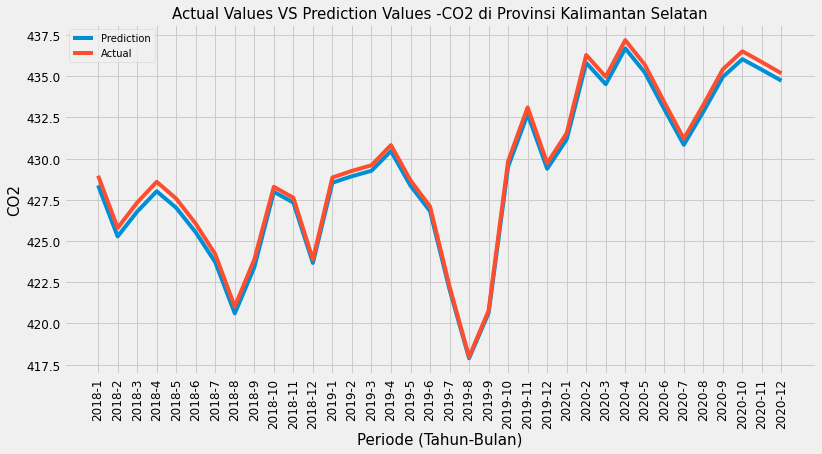

explained_variance:  0.9995
r2:  0.9929
MAE:  0.348
MSE:  0.1297
RMSE:  0.3602



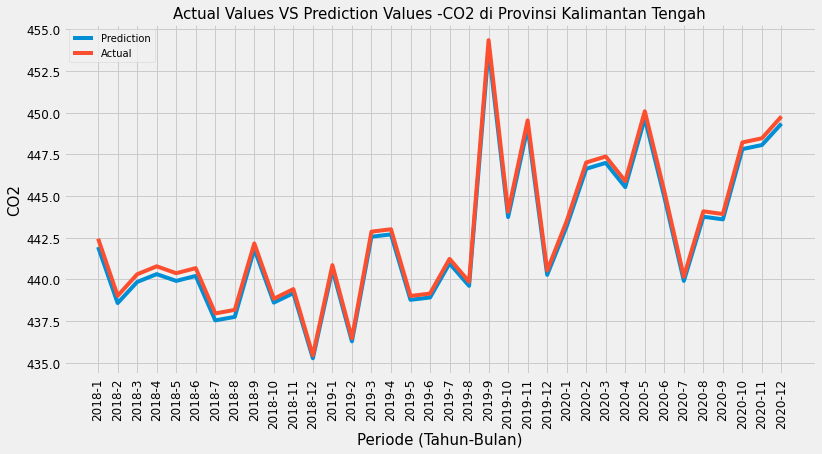

explained_variance:  0.9994
r2:  0.9909
MAE:  0.3977
MSE:  0.1688
RMSE:  0.4109



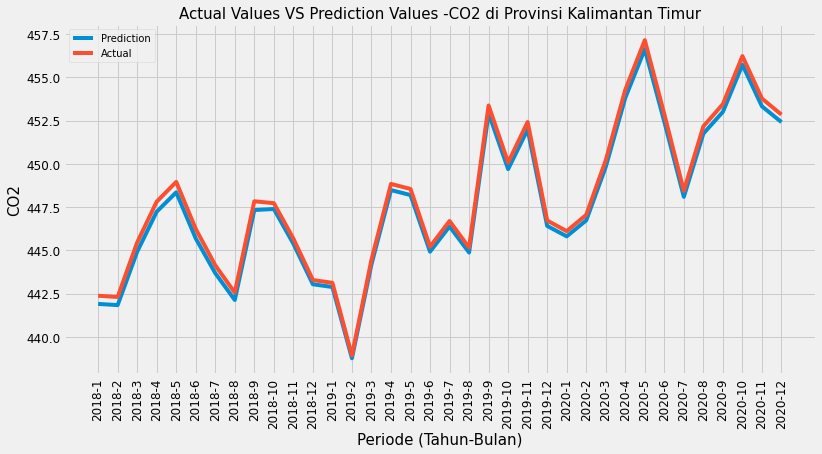

explained_variance:  0.9996
r2:  0.9931
MAE:  0.3821
MSE:  0.1551
RMSE:  0.3938



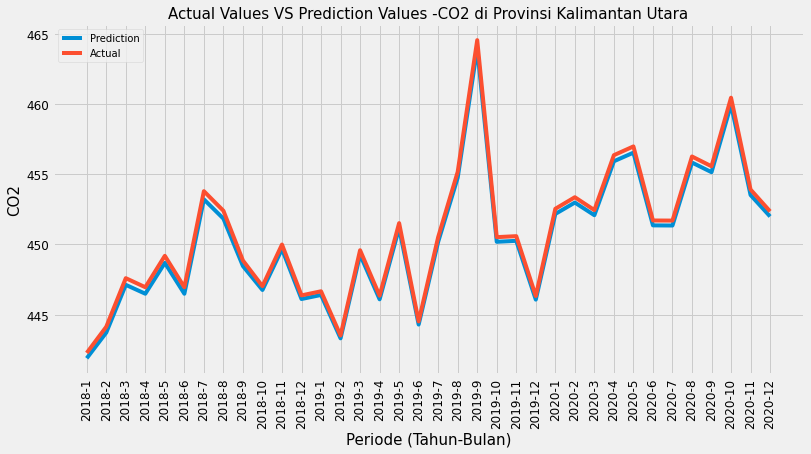

explained_variance:  0.9991
r2:  0.9837
MAE:  0.3928
MSE:  0.1632
RMSE:  0.404



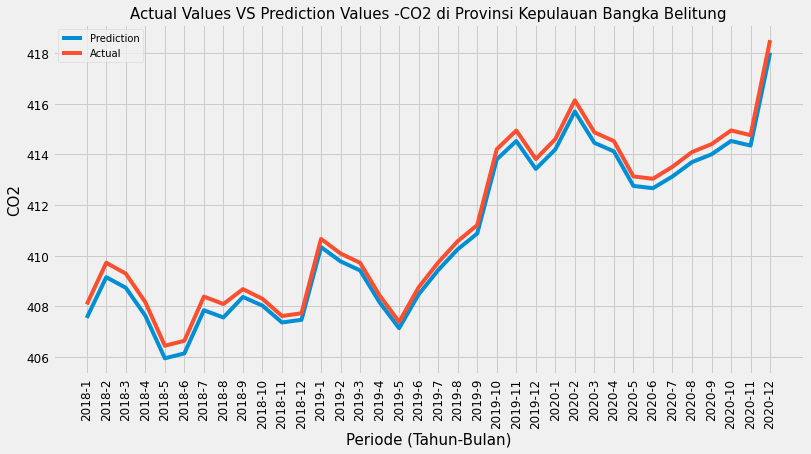

explained_variance:  0.9989
r2:  0.9777
MAE:  0.4642
MSE:  0.2271
RMSE:  0.4765



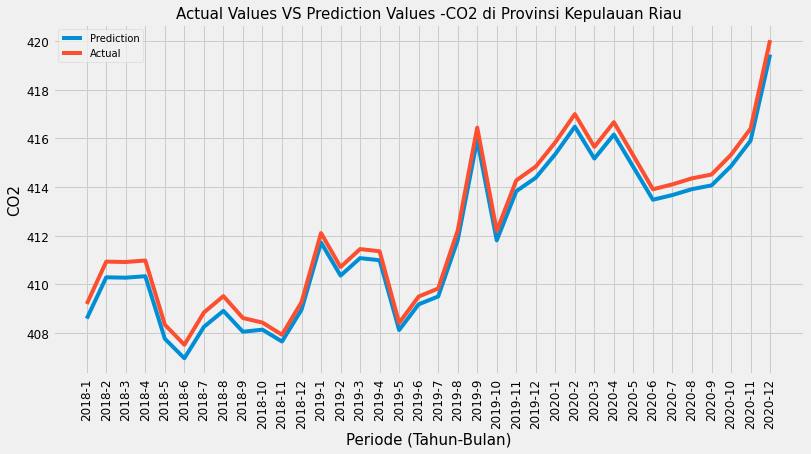

explained_variance:  0.9997
r2:  0.997
MAE:  0.3048
MSE:  0.1041
RMSE:  0.3227



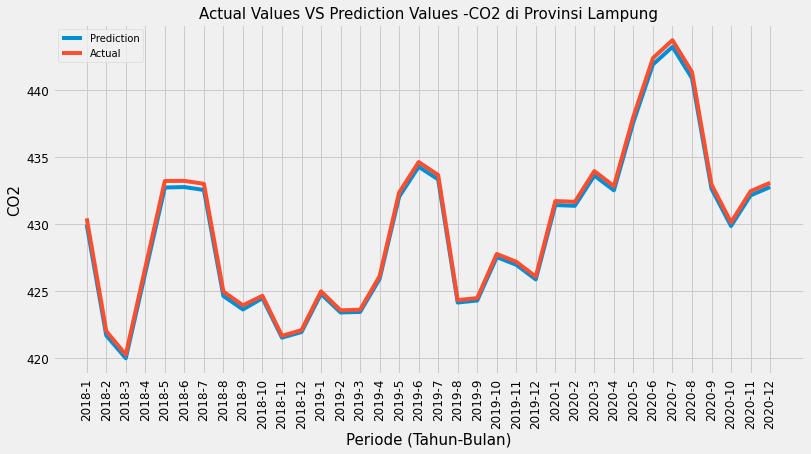

explained_variance:  0.9991
r2:  0.9746
MAE:  0.5118
MSE:  0.2721
RMSE:  0.5216



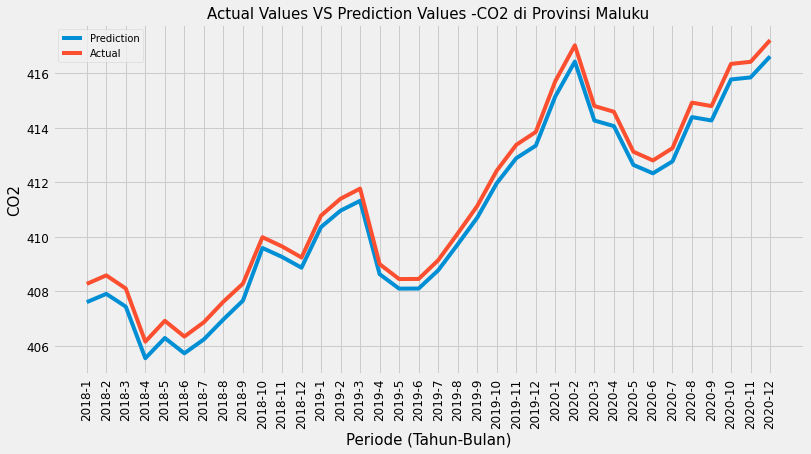

explained_variance:  0.999
r2:  0.9732
MAE:  0.502
MSE:  0.2621
RMSE:  0.5119



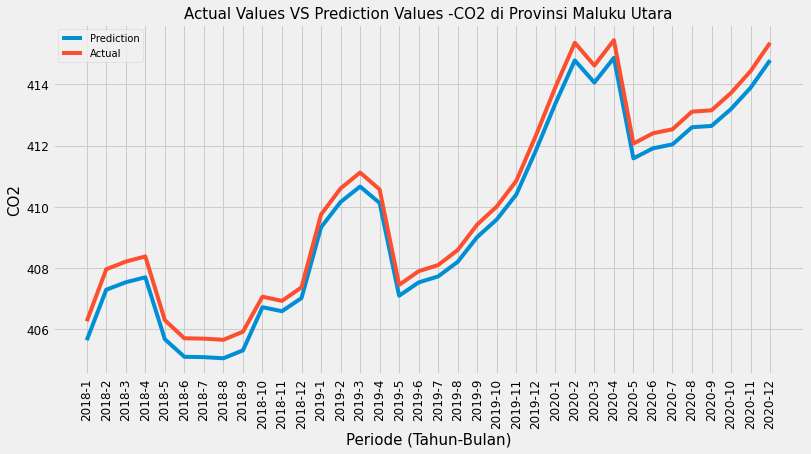

explained_variance:  0.9991
r2:  0.9804
MAE:  0.4823
MSE:  0.2435
RMSE:  0.4935



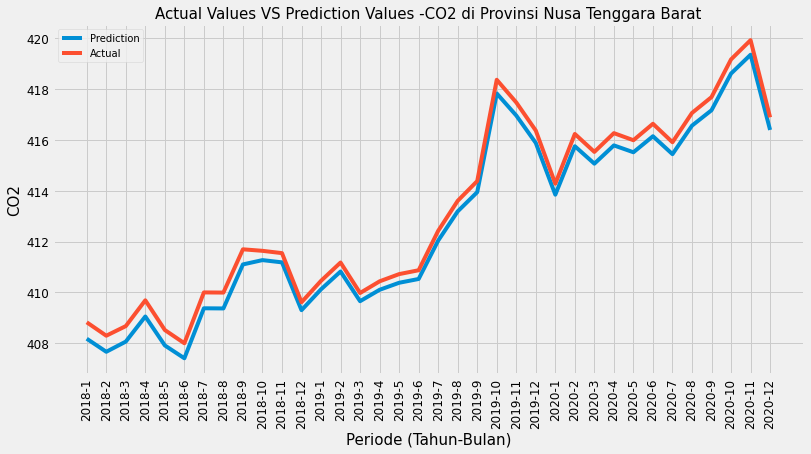

explained_variance:  0.9989
r2:  0.9764
MAE:  0.4928
MSE:  0.2544
RMSE:  0.5043



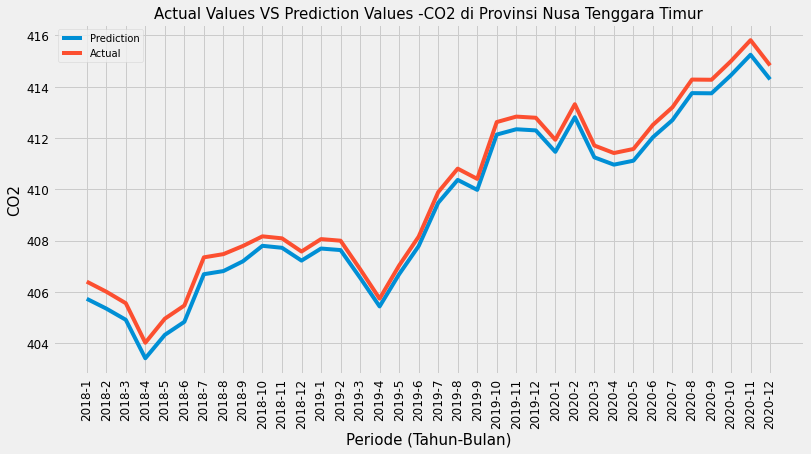

explained_variance:  0.9994
r2:  0.9921
MAE:  0.3932
MSE:  0.1677
RMSE:  0.4095



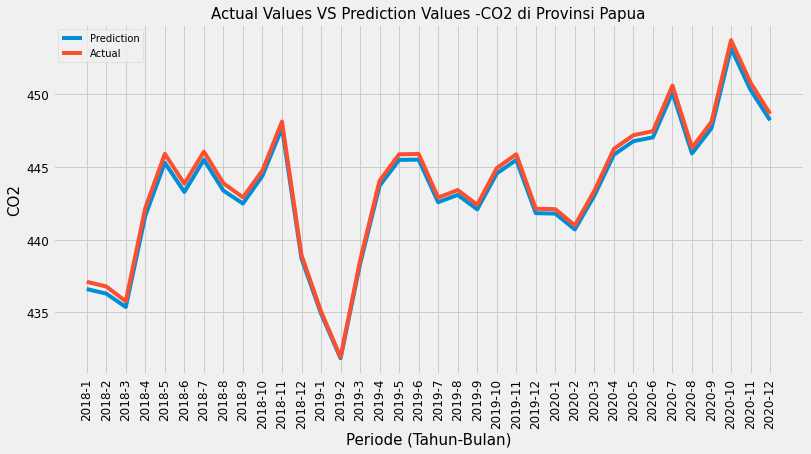

explained_variance:  0.9993
r2:  0.9895
MAE:  0.4503
MSE:  0.2167
RMSE:  0.4656



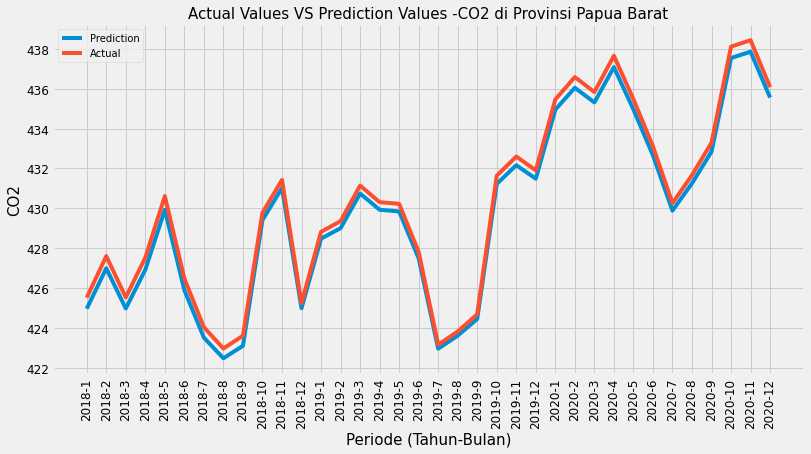

explained_variance:  0.9999
r2:  0.9994
MAE:  0.1975
MSE:  0.0469
RMSE:  0.2165



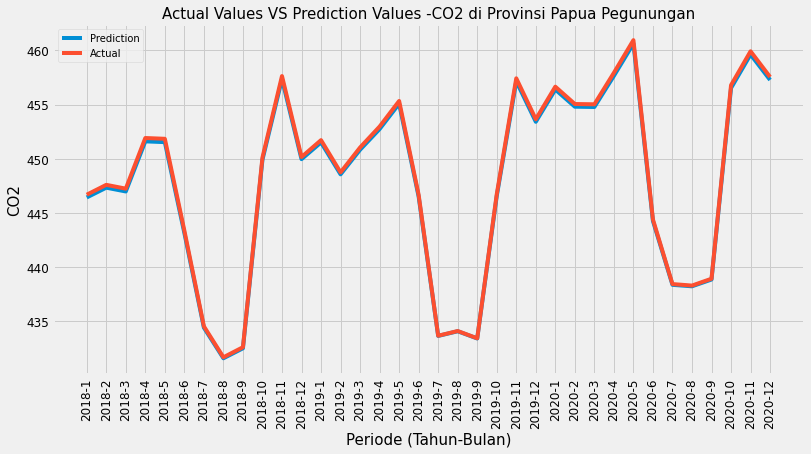

explained_variance:  0.9996
r2:  0.9931
MAE:  0.392
MSE:  0.164
RMSE:  0.405



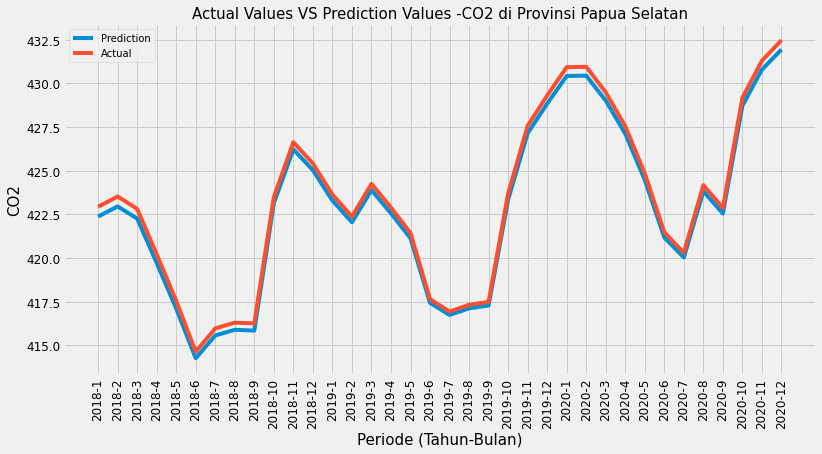

explained_variance:  0.9993
r2:  0.9881
MAE:  0.4183
MSE:  0.1856
RMSE:  0.4308



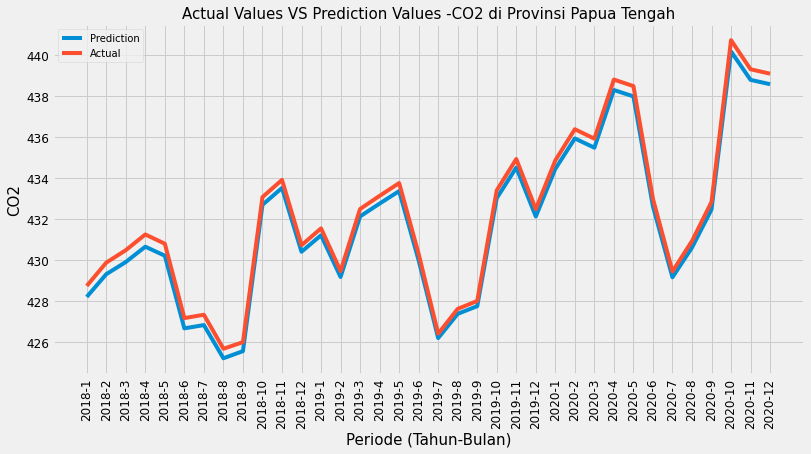

explained_variance:  0.9997
r2:  0.9962
MAE:  0.304
MSE:  0.0998
RMSE:  0.316



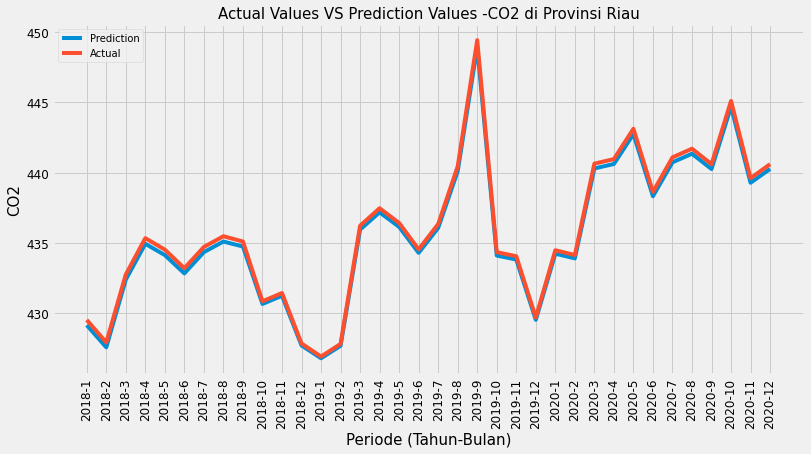

explained_variance:  0.9994
r2:  0.9878
MAE:  0.4258
MSE:  0.1907
RMSE:  0.4366



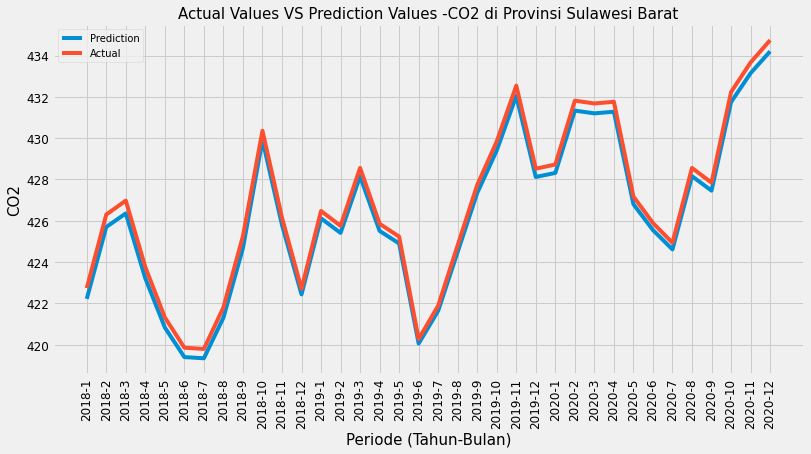

explained_variance:  0.9991
r2:  0.9799
MAE:  0.4806
MSE:  0.242
RMSE:  0.492



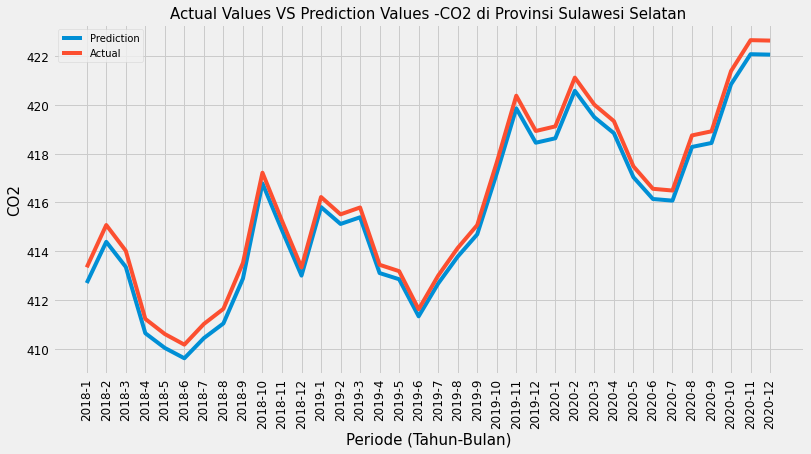

explained_variance:  0.9991
r2:  0.9792
MAE:  0.4809
MSE:  0.2416
RMSE:  0.4915



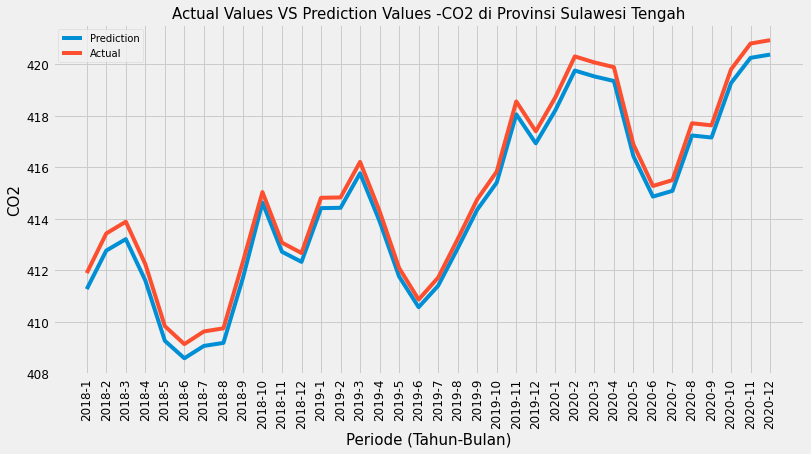

explained_variance:  0.999
r2:  0.9815
MAE:  0.473
MSE:  0.2366
RMSE:  0.4865



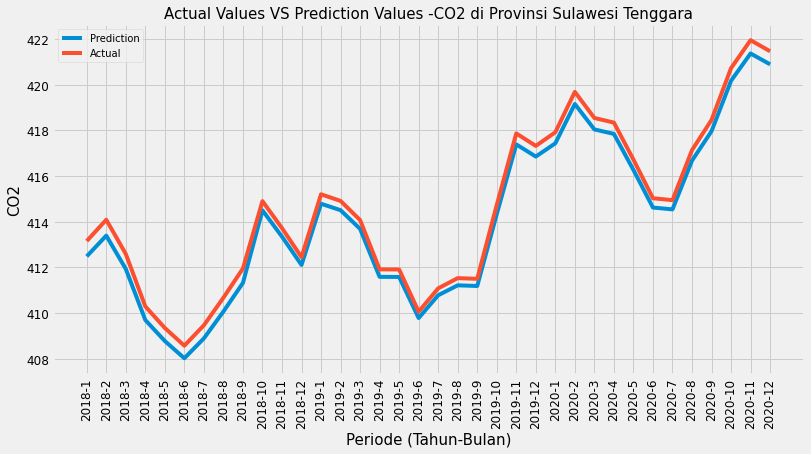

explained_variance:  0.999
r2:  0.9753
MAE:  0.4889
MSE:  0.2494
RMSE:  0.4994



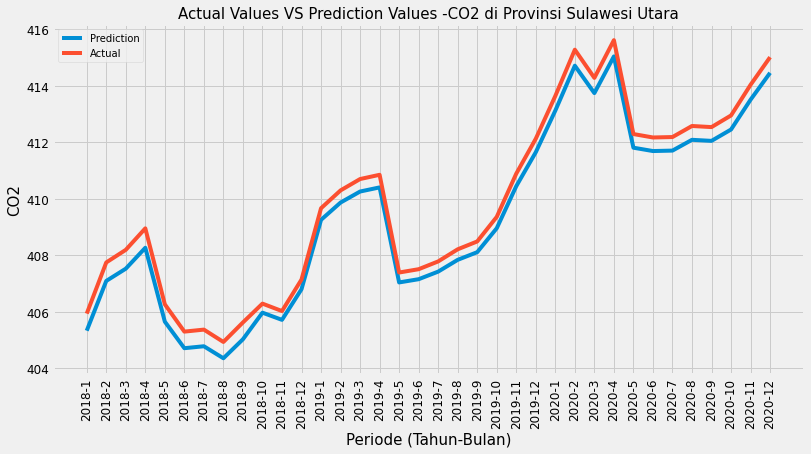

explained_variance:  0.9995
r2:  0.9913
MAE:  0.3861
MSE:  0.1574
RMSE:  0.3967



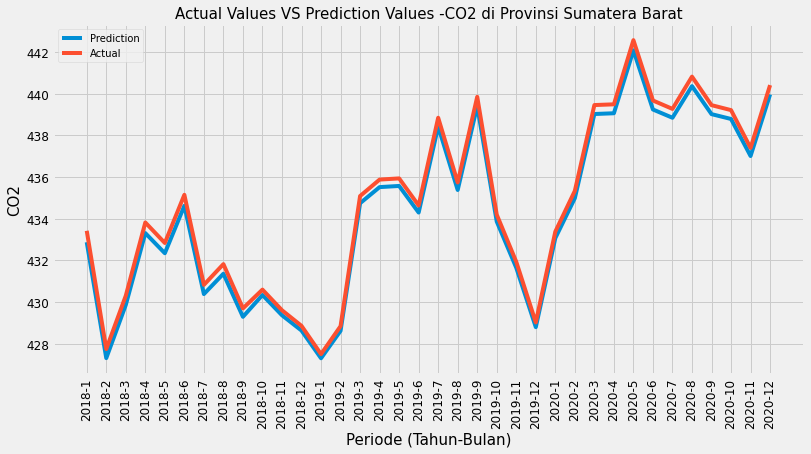

explained_variance:  0.9997
r2:  0.9965
MAE:  0.2547
MSE:  0.0704
RMSE:  0.2654



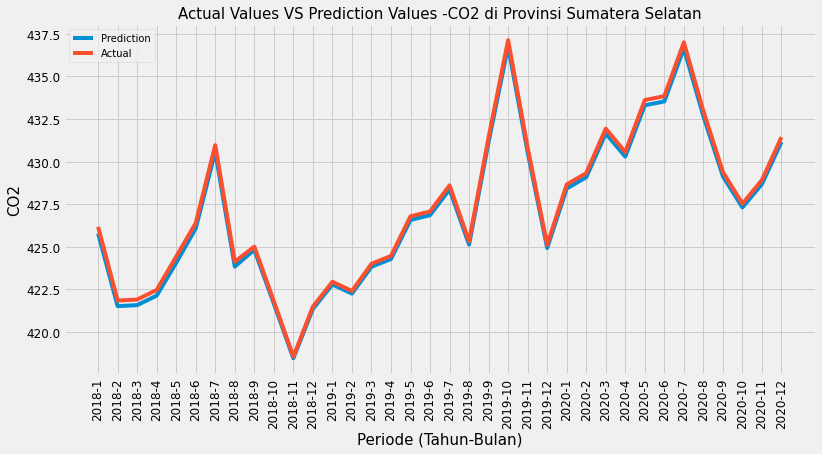

explained_variance:  0.9994
r2:  0.9875
MAE:  0.3844
MSE:  0.1555
RMSE:  0.3944



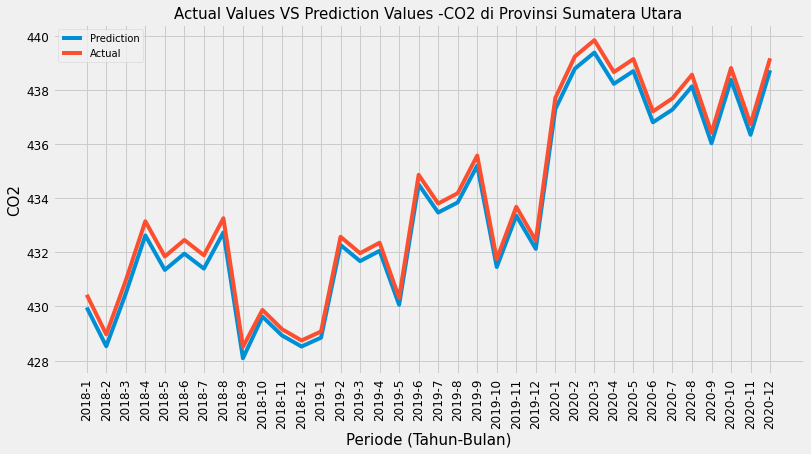

In [14]:
for i in df.Provinsi.unique():
    train_data=df_train[df_train.Provinsi==i]
    test_data=df_test[df_test.Provinsi==i]
    train_data.drop('Provinsi', axis=1, inplace=True)
    test_data.drop('Provinsi', axis=1, inplace=True)
    cat_features = ['Month','quarter']
    X_train, y_train = create_features(train_data, label='CO2')
    X_test, y_test = create_features(test_data, label='CO2')
    X_train.fillna(0, inplace=True)
    X_test.fillna(0, inplace=True)
    model = Lasso()
    model.fit(X_train, y_train)
    test_data['Prediction'] = model.predict(X_test)
    test_data['period']=test_data['Year'].astype(str)+"-"+test_data['Month'].astype(str)
    display(HTML('<H3 style="color:blue"> <b>Evaluasi Model - CO2 di Provinsi {} </b></H5><hr>'.format(i)))
    print(regression_results(test_data['CO2'], test_data['Prediction']))
    plt.figure(figsize=(12,6))
    plt.plot(test_data.period.tolist(), test_data['Prediction'].tolist(), label='Prediction')
    plt.plot(test_data.period.tolist(), test_data['CO2'].tolist(), label='Actual')
    plt.xticks(size=12, rotation='vertical')
    plt.yticks(size=12)
    plt.ylabel('CO2',fontsize=15)
    plt.xlabel('Periode (Tahun-Bulan)',fontsize=15)
    plt.title('Actual Values VS Prediction Values -CO2 di Provinsi {}'.format(string.capwords(i)),fontsize=15)
    plt.legend(fontsize=10, loc=2)
    plt.show()